In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from pathlib import Path
import json
from courtvision.data import (
    PadelDataset,
    get_keypoints_as_dict,
    CourtVisionDataset,
    dict_to_points,
)
from courtvision.vis import draw_rect, load_image, draw_points, plot_3d_points
from courtvision.geometry import corners_world_3d, convert_obj_points_to_planar
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [30]:
CALIBRATION_DATA_PATH = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/calibrations/v1/project-1-at-2023-06-05-11-03-246a0246.json"
)
DATA_ROOT = Path(
    "/Users/benjamindecharmoy/projects/courtvision/courtvision_balldetector/data/labelstudiodata/media"
)

In [31]:
with open(CALIBRATION_DATA_PATH, "r") as fp:
    calibration_keypoints = PadelDataset(samples=json.load(fp))

image = load_image(
    CourtVisionDataset.find_image_path(
        DATA_ROOT, sample=calibration_keypoints.samples[0]
    )
)

['a_front_left', 'b_front_right', 'c_back_left', 'd_back_right', 'e_left_near_serve_line', 'f_right_near_serve_line', 'g_left_far_serve_line', 'h_right_far_serve_line', 'i_center_line_far', 'j_net_line_left', 'k_center_line_near', 'l_net_line_right', 'm_top_front_left', 'n_top_front_right', 'o_top_back_left', 'p_top_back_right', 'q_top_net_line_left', 'r_top_net_line_right', 's_top_net_center', 't_center_center', 'u_topfence_front_left', 'v_topfence_front_right', 'w_topfence_back_left', 'x_topfence_back_right', 'y_top_center_left', 'z_top_center_right']


(<matplotlib.image.AxesImage at 0x2d27cb450>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

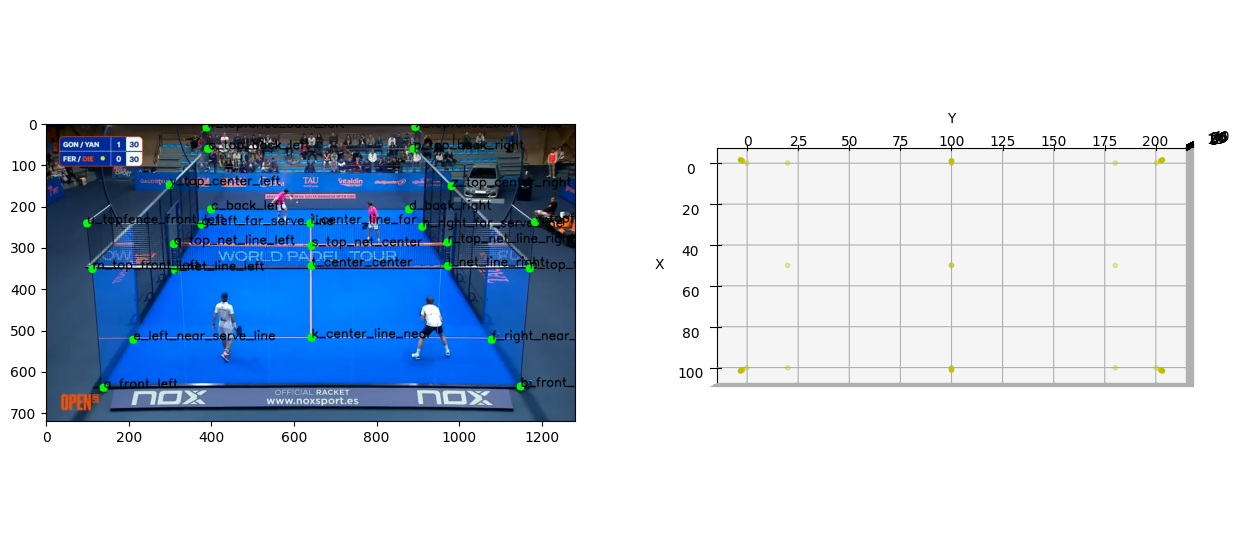

In [32]:
keypoint_dict = get_keypoints_as_dict(
    calibration_keypoints.samples[0].annotations[0].result
)
world_points, world_labels = dict_to_points(corners_world_3d)
keypoints, labels = dict_to_points(keypoint_dict)
assert all([l1 == l2 for l1, l2 in zip(labels, world_labels)])
print(labels)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(draw_points(image.copy(), keypoints, labels=labels)), plot_3d_points(
    x=world_points[:, 0], y=world_points[:, 1], z=world_points[:, 2], plt_axis=ax2
)

['a_front_left',
 'b_front_right',
 'c_back_left',
 'd_back_right',
 'e_left_near_serve_line',
 'f_right_near_serve_line',
 'g_left_far_serve_line',
 'h_right_far_serve_line',
 'i_center_line_far',
 'j_net_line_left',
 'k_center_line_near',
 'l_net_line_right',
 't_center_center']

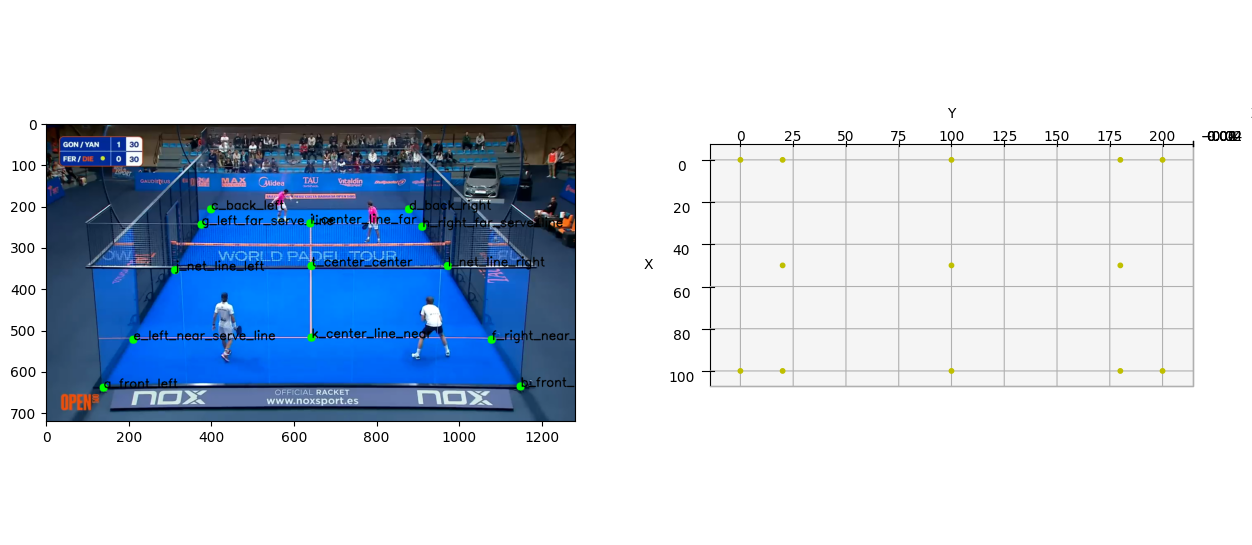

In [33]:
#  Group points into common horizontal planes
floor_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "top" not in k)
floor_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "top" not in k
)
floor_plane_world_points, floor_plane_world_labels = dict_to_points(
    floor_plane_world_dict
)
floor_plane_keypoints, floor_plane_labels = dict_to_points(floor_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), floor_plane_keypoints, labels=floor_plane_labels)
), plot_3d_points(
    x=floor_plane_world_points[:, 0],
    y=floor_plane_world_points[:, 1],
    z=floor_plane_world_points[:, 2],
    plt_axis=ax2,
)
floor_plane_labels

(<matplotlib.image.AxesImage at 0x2d31e7c10>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

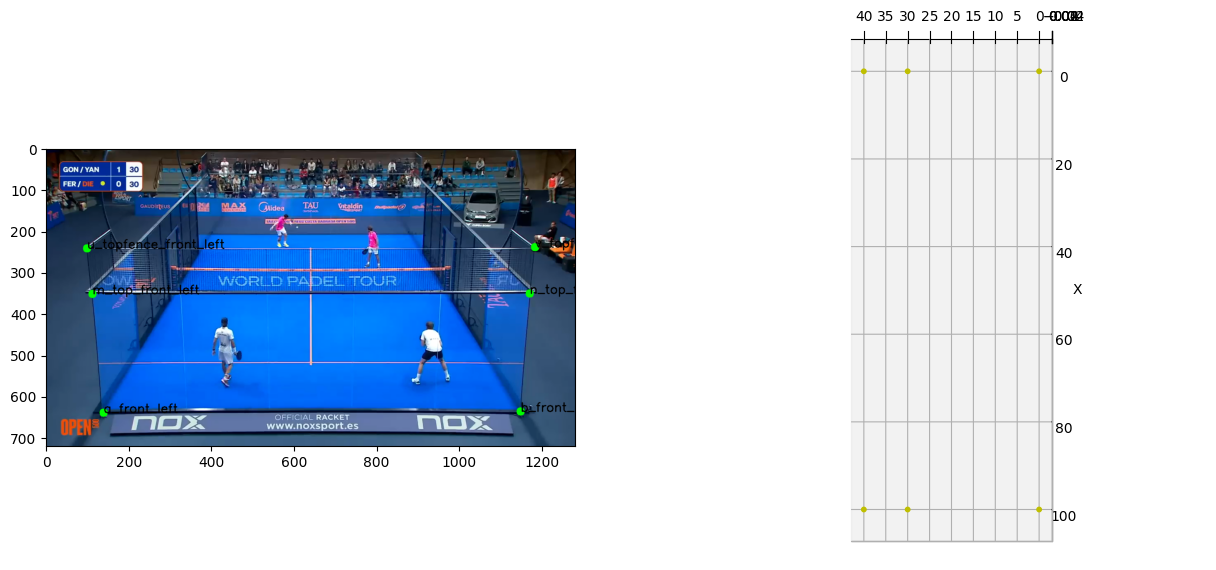

In [34]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
front_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "front" in k)
front_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "front" in k
)
front_wall_plane_world_points, front_wall_plane_world_labels = dict_to_points(
    front_wall_plane_world_dict
)
front_wall_plane_keypoints, front_wall_plane_labels = dict_to_points(
    front_wall_plane_dict
)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(
        image.copy(), front_wall_plane_keypoints, labels=front_wall_plane_labels
    )
), plot_3d_points(
    x=front_wall_plane_world_points[:, 0],
    y=front_wall_plane_world_points[:, 1],
    z=front_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 90),
)

(<matplotlib.image.AxesImage at 0x2d33c3510>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

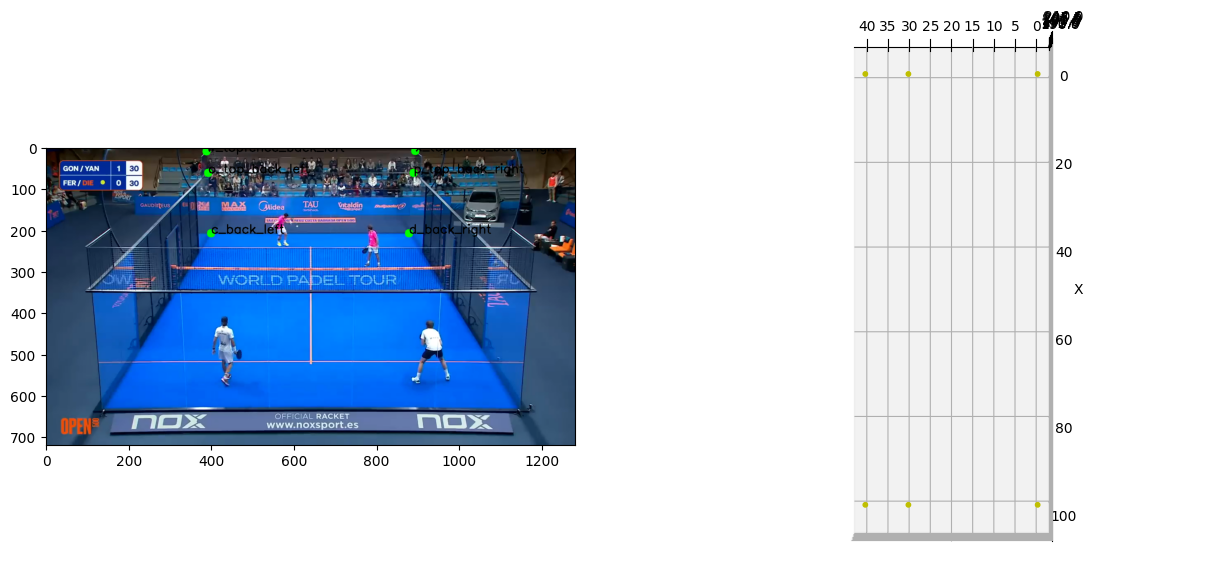

In [35]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
back_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "back" in k)
back_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "back" in k
)
back_wall_plane_world_points, back_wall_plane_world_labels = dict_to_points(
    back_wall_plane_world_dict
)
back_wall_plane_keypoints, back_wall_plane_labels = dict_to_points(back_wall_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), back_wall_plane_keypoints, labels=back_wall_plane_labels)
), plot_3d_points(
    x=back_wall_plane_world_points[:, 0],
    y=back_wall_plane_world_points[:, 1],
    z=back_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 90),
)

(<matplotlib.image.AxesImage at 0x2d347f050>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

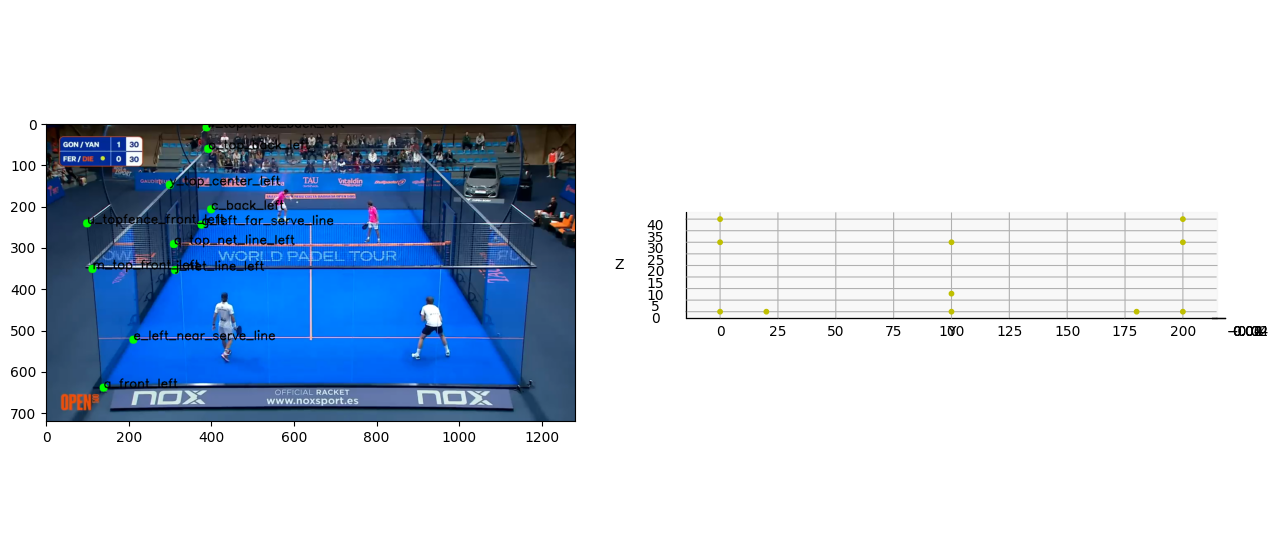

In [36]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
left_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "left" in k)
left_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "left" in k
)
left_wall_plane_world_points, left_wall_plane_world_labels = dict_to_points(
    left_wall_plane_world_dict
)
left_wall_plane_keypoints, left_wall_plane_labels = dict_to_points(left_wall_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), left_wall_plane_keypoints, labels=left_wall_plane_labels)
), plot_3d_points(
    x=left_wall_plane_world_points[:, 0],
    y=left_wall_plane_world_points[:, 1],
    z=left_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 0, 0),
)

(<matplotlib.image.AxesImage at 0x2d277d5d0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

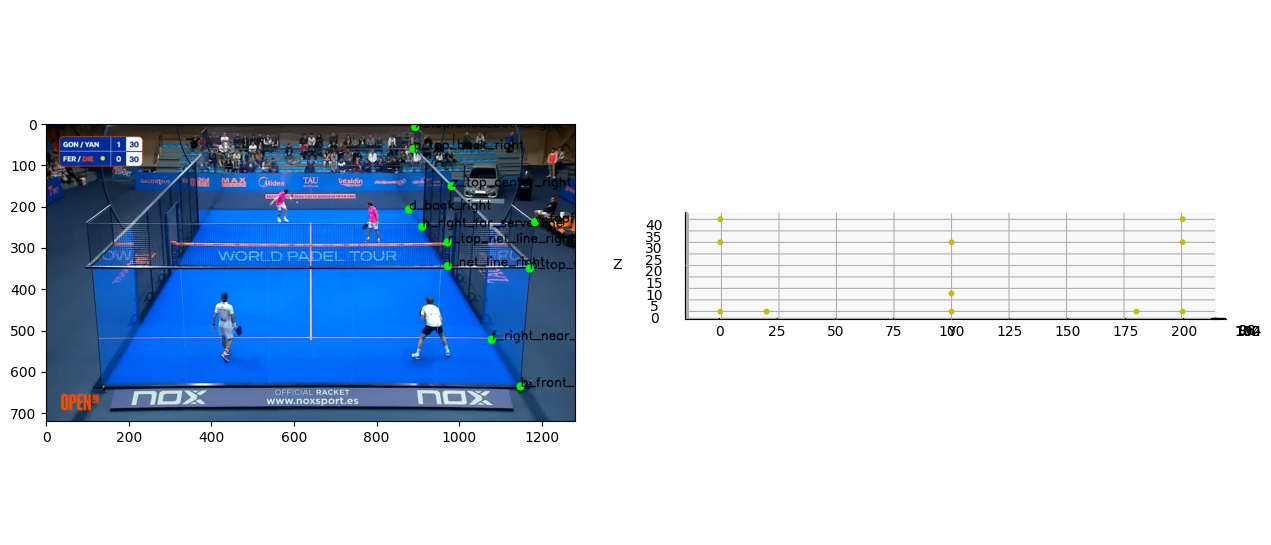

In [37]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
right_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "right" in k)
right_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "right" in k
)
right_wall_plane_world_points, right_wall_plane_world_labels = dict_to_points(
    right_wall_plane_world_dict
)
right_wall_plane_keypoints, right_wall_plane_labels = dict_to_points(
    right_wall_plane_dict
)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(
        image.copy(), right_wall_plane_keypoints, labels=right_wall_plane_labels
    )
), plot_3d_points(
    x=right_wall_plane_world_points[:, 0],
    y=right_wall_plane_world_points[:, 1],
    z=right_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 0, 0),
)

(<matplotlib.image.AxesImage at 0x2d37aa590>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

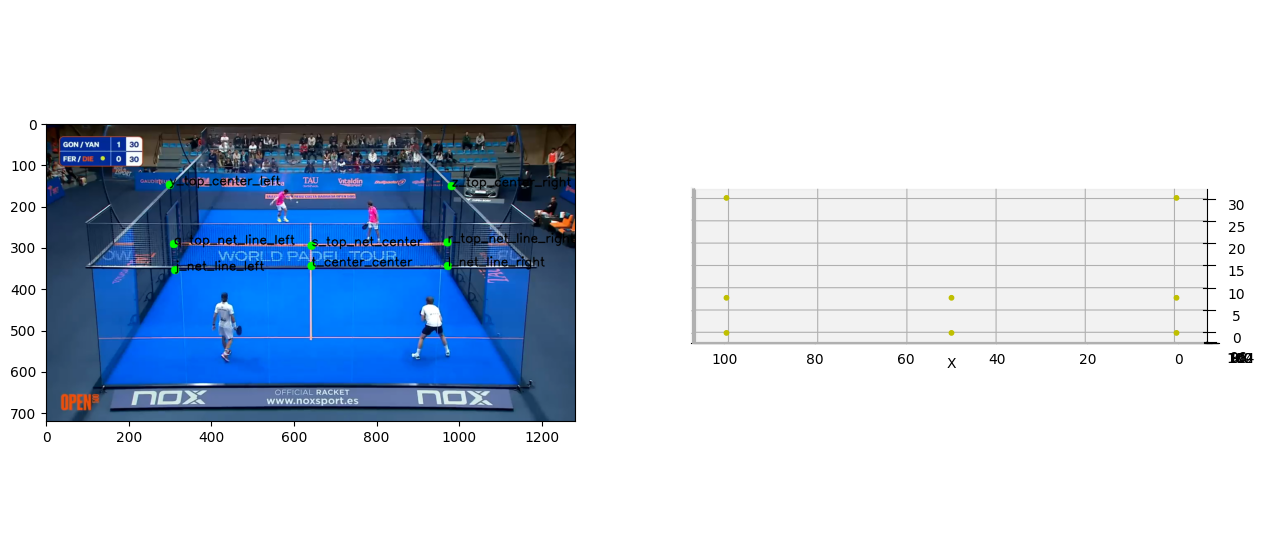

In [38]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
net_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "net" in k or k in ["y_top_center_left", "z_top_center_right", "t_center_center"]
)
net_plane_world_dict = dict(
    (k, v)
    for k, v in corners_world_3d.items()
    if "net" in k or k in ["y_top_center_left", "z_top_center_right", "t_center_center"]
)

net_plane_world_points, net_plane_world_labels = dict_to_points(net_plane_world_dict)
net_plane_keypoints, net_plane_labels = dict_to_points(net_plane_dict)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), net_plane_keypoints, labels=net_plane_labels)
), plot_3d_points(
    x=net_plane_world_points[:, 0],
    y=net_plane_world_points[:, 1],
    z=net_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 0),
)

(<matplotlib.image.AxesImage at 0x2d3873890>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

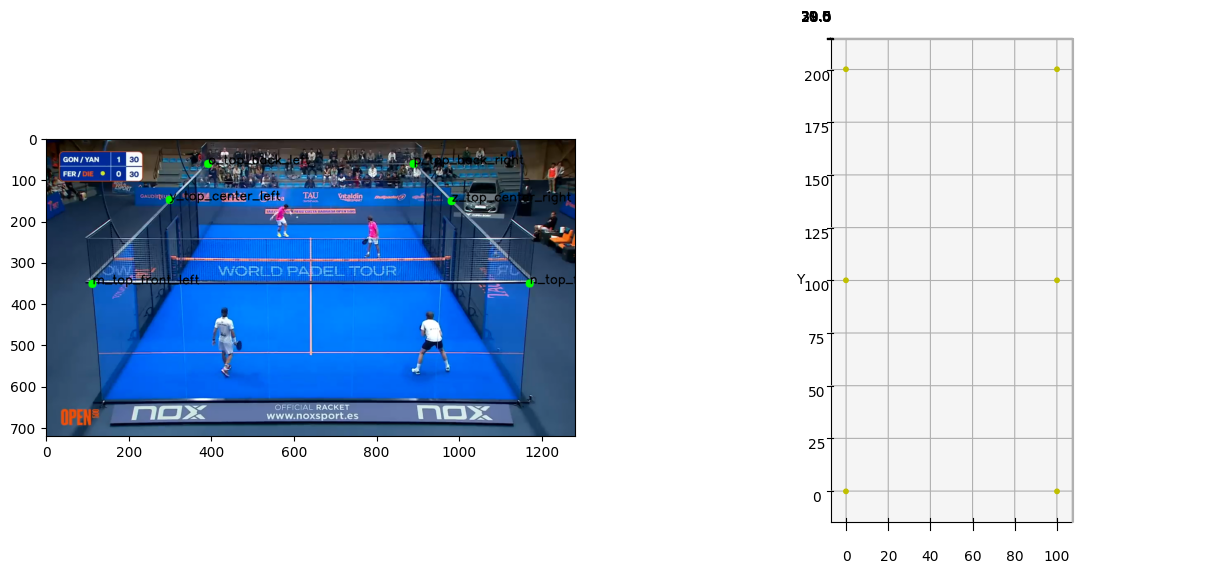

In [39]:
# Group points into common horizontal planes (top and topfence)
top_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "top" in k and not "fence" in k and not "net" in k
)
top_plane_world_dict = dict(
    (k, v)
    for k, v in corners_world_3d.items()
    if "top" in k and not "fence" in k and not "net" in k
)
top_plane_world_points, top_plane_world_labels = dict_to_points(top_plane_world_dict)
top_plane_keypoints, top_plane_labels = dict_to_points(top_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), top_plane_keypoints, labels=top_plane_labels)
), plot_3d_points(
    x=top_plane_world_points[:, 0],
    y=top_plane_world_points[:, 1],
    z=top_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(90, 0, 90),
)

(<matplotlib.image.AxesImage at 0x2d3827fd0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

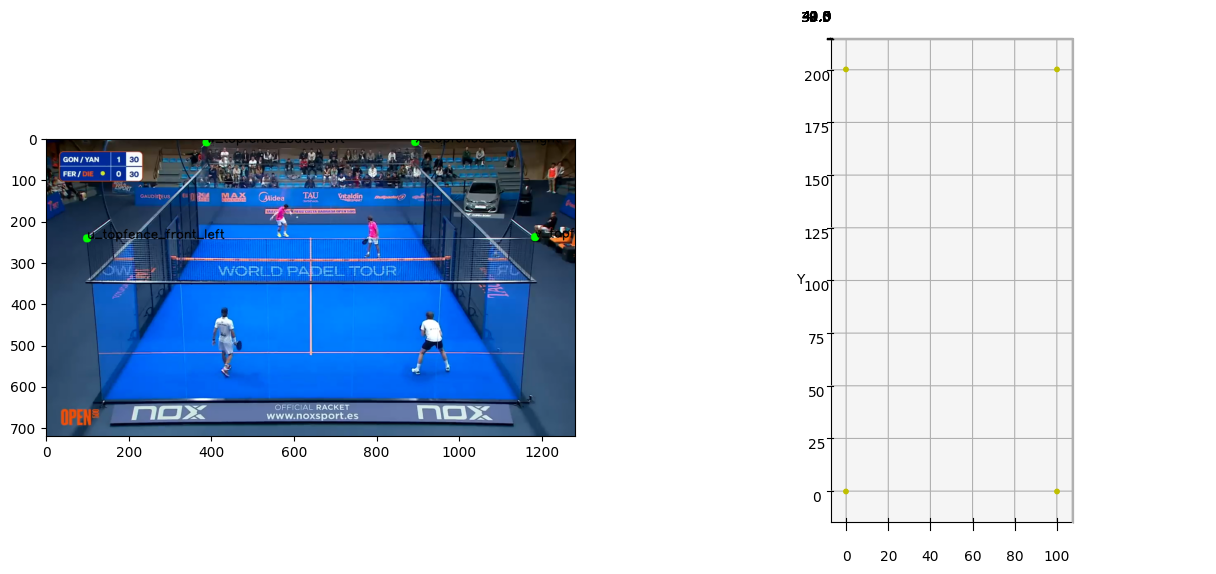

In [40]:
# Group points into common horizontal planes (top and topfence)
topfence_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "topfence" in k)
topfence_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "topfence" in k
)

topfence_plane_world_points, topfence_plane_world_labels = dict_to_points(
    topfence_plane_world_dict
)

topfence_plane_keypoints, topfence_plane_labels = dict_to_points(topfence_plane_dict)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), topfence_plane_keypoints, labels=topfence_plane_labels)
), plot_3d_points(
    x=topfence_plane_world_points[:, 0],
    y=topfence_plane_world_points[:, 1],
    z=topfence_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(90, 0, 90),
)

In [41]:
dd = 5
calibration_data = [
    (floor_plane_keypoints[:4], floor_plane_world_points[:4]),
    (front_wall_plane_keypoints[:4], front_wall_plane_world_points[:4]),
    (back_wall_plane_keypoints[:4], back_wall_plane_world_points[:4]),
    # (left_wall_plane_keypoints[:4], left_wall_plane_world_points[:4]),
    # (right_wall_plane_keypoints[:4], right_wall_plane_world_points[:4]),
    (net_plane_keypoints[:4], net_plane_world_points[:4]),
    (top_plane_keypoints[:4], top_plane_world_points[:4]),
    (topfence_plane_keypoints, topfence_plane_world_points),
]
repo_erro, camera_matrix, dist_coeffs, *_ = cv2.calibrateCamera(
    objectPoints=[convert_obj_points_to_planar(obj) for _, obj in calibration_data],
    imagePoints=[img for img, _ in calibration_data],
    imageSize=(image.shape[1], image.shape[0]),
    cameraMatrix=None,
    distCoeffs=None,
)
print(f"{repo_erro=}")

repo_erro=0.30970941724150186


success=True
reprojection_error=34.37877


(<matplotlib.image.AxesImage at 0x2d41aa590>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

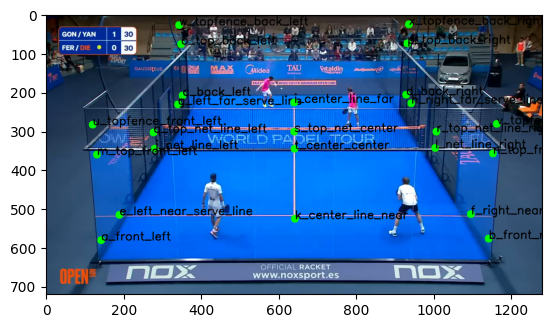

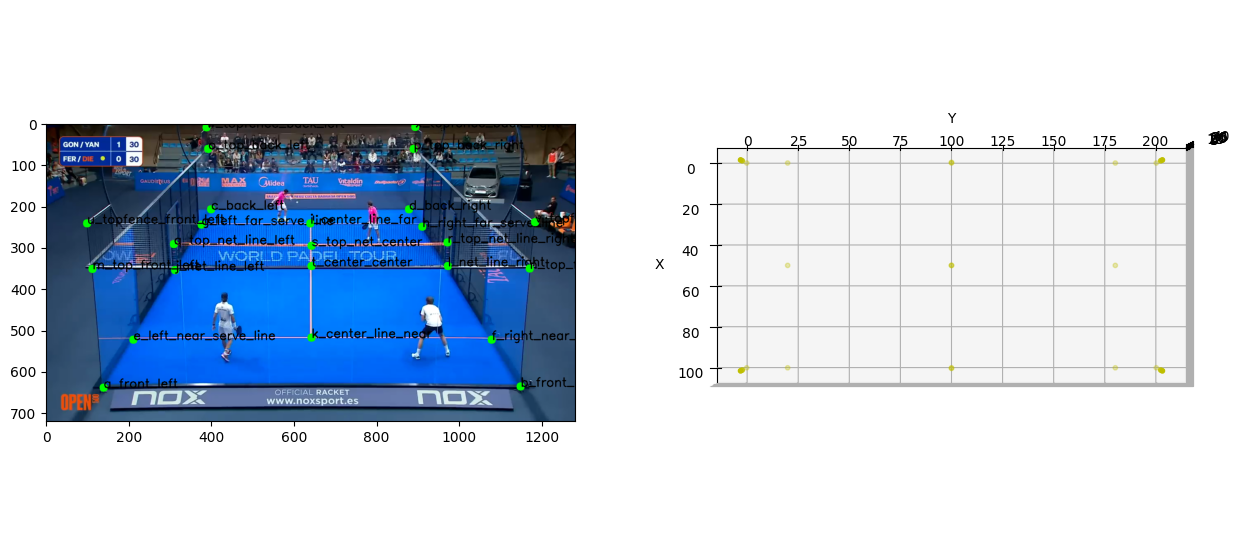

In [48]:
h, w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coeffs, (w, h), 1, (w, h), False
)

# dst = cv2.undistort(image, camera_matrix, dist_coeffs, None, newcameramtx)
# image_points_array_undist = np.array(
#     [
#         (x, y)
#         for x, y in cv2.undistortPoints(
#             image_points_array, camera_matrix, dist_coeffs, None, newcameramtx
#         ).squeeze()
#     ]
# )
num_pose_points = 24
success, rvec, tvec = cv2.solvePnP(
    world_points[:num_pose_points],
    keypoints[:num_pose_points],
    newcameramtx,
    dist_coeffs,
    # None,
    flags=cv2.SOLVEPNP_ITERATIVE,
    useExtrinsicGuess=False,
)


print(f"{success=}")
reprojected_image_points, _ = cv2.projectPoints(
    world_points[:num_pose_points],
    rvec,
    tvec,
    newcameramtx,
    dist_coeffs,
)
reprojected_image_points = reprojected_image_points.reshape(-1, 2)
reprojection_error = np.linalg.norm(
    reprojected_image_points[:num_pose_points] - keypoints[:num_pose_points], axis=1
).mean()
print(f"{reprojection_error=}")
plt.imshow(draw_points(image.copy(), reprojected_image_points, labels=labels))
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), keypoints[:num_pose_points], labels=labels)
), plot_3d_points(
    x=world_points[:num_pose_points, 0],
    y=world_points[:num_pose_points, 1],
    z=world_points[:num_pose_points, 2],
    plt_axis=ax2,
)

In [213]:
import numpy as np


def convert_obj_points_to_planar_2(object_points: np.array) -> np.array:
    """Converts object points to planar points by finding the common axis and permuting the points so that the common axis is the last axis.
    Assumes that the object points are planar.

    Args:
        object_points (np.array): _description_

    Raises:
        ValueError: When points are not planar

    Returns:
        np.array: _description_
    """
    common_axis = None
    for axis in [0, 1, 2]:
        if all(object_points[0, axis] == o for o in object_points[:, axis]):
            common_axis = axis
            break
    if common_axis is None:
        raise ValueError("Could not find common axis")
    # permute the object points so that the common axis is the last axis
    return np.expand_dims(
        np.concatenate(
            [
                object_points[:, [i for i in range(3) if i != common_axis]],
                np.zeros((object_points.shape[0], 1)),
            ],
            axis=1,
        ),
        axis=0,
    ).astype(np.float32)


convert_obj_points_to_planar_2(floor_plane_world_points).shape

(1, 13, 3)

In [164]:
dd[:, -1]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [178]:
print(back_wall_plane_world_points)
convert_obj_points_to_planar(back_wall_plane_world_points)

[[  0. 200.   0.]
 [100. 200.   0.]
 [  0. 200.  30.]
 [100. 200.  30.]
 [  0. 200.  40.]
 [100. 200.  40.]]


array([[  0.,   0.,   0.],
       [100.,   0.,   0.],
       [  0.,  30.,   0.],
       [100.,  30.,   0.],
       [  0.,  40.,   0.],
       [100.,  40.,   0.]])

In [138]:
dd = [convert_obj_points_to_planar(obj) for _, obj in calibration_data]

common_axis=2
tmp=array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0., 200.,   0.],
       [100., 200.,   0.],
       [  0.,  20.,   0.],
       [100.,  20.,   0.],
       [  0., 180.,   0.],
       [100., 180.,   0.],
       [ 50., 180.,   0.],
       [  0., 100.,   0.],
       [ 50.,  20.,   0.],
       [100., 100.,   0.],
       [ 50., 100.,   0.]], dtype=float32)
common_axis=1
tmp=array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,  30.,   0.],
       [100.,  30.,   0.],
       [  0.,  40.,   0.],
       [100.,  40.,   0.]], dtype=float32)
common_axis=1
tmp=array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,  30., 200.],
       [100.,  30., 200.],
       [  0.,  40., 200.],
       [100.,  40., 200.]], dtype=float32)
common_axis=0
tmp=array([[  0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ],
       [ 20. ,   0. ,   0. ],
       [180. ,   0. ,   0. ],
       [100. ,   0. ,   0. ],
       [  0. ,  30. ,   0. ],
       [200. ,  30. ,   0